In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
import torch, os, pickle, gc, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [55]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

In [ ]:
data

In [6]:
data=pd.read_csv('BTC-Hourly.csv')
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [7]:
# inverse data order
data=data.iloc[::-1]

# drop irrelevant columns
data=data.drop(['unix', 'symbol'], axis=1)
data.head()

,date,open,high,low,close,Volume BTC,Volume USD
33258,2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
33257,2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
33256,2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
33255,2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
33254,2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


# EDA

In [8]:
data.describe()

,open,high,low,close,Volume BTC,Volume USD
count,33259.000000,33259.000000,33259.000000,33259.000000,3.325900e+04,3.325900e+04
mean,20119.546772,20232.957473,19997.069777,20120.684800,1.612380e+06,2.965701e+06
std,18537.219607,18646.950933,18418.320297,18537.695044,3.102328e+06,7.329787e+06
min,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00,0.000000e+00
25%,7022.865000,7055.835000,6970.570000,7022.865000,1.903241e+02,1.682800e+02
50%,9700.040000,9740.270000,9657.000000,9700.320000,6.093271e+05,5.248300e+02
75%,36415.305000,36735.380000,36104.235000,36423.040000,1.929240e+06,3.120014e+06
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 33258 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        33259 non-null  object 
 1   open        33259 non-null  float64
 2   high        33259 non-null  float64
 3   low         33259 non-null  float64
 4   close       33259 non-null  float64
 5   Volume BTC  33259 non-null  float64
 6   Volume USD  33259 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.8+ MB


In [10]:
data['date']=data['date'].astype('datetime64[ns]')
data.info()
pd.to_datetime(data['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 33258 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        33259 non-null  datetime64[ns]
 1   open        33259 non-null  float64       
 2   high        33259 non-null  float64       
 3   low         33259 non-null  float64       
 4   close       33259 non-null  float64       
 5   Volume BTC  33259 non-null  float64       
 6   Volume USD  33259 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.8 MB


In [11]:
# to check for null values
data.isnull().sum()

date          0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

In [12]:
# to check for null values
data.isin([np.inf, -np.inf]).sum()

date          0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

In [13]:
# to check for occurances where the difference between consecutive timestamps is not one hour.
data=data.set_index('date')
(data.index[1:] - data.index[:-1]).value_counts()

0 days 01:00:00    33258
Name: date, dtype: int64

In [14]:
data.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [15]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(data["close"]).rename(columns={"close": "Price"})
bitcoin_prices.head()

,Price
date,
2018-05-15 06:00:00,8740.99
2018-05-15 07:00:00,8739.00
2018-05-15 08:00:00,8728.49
2018-05-15 09:00:00,8708.32
2018-05-15 10:00:00,8795.90


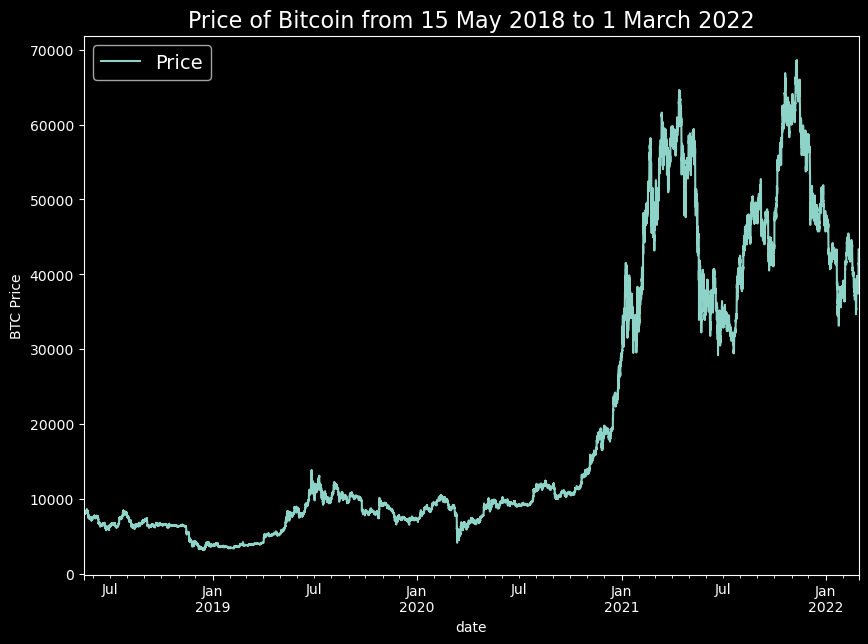

In [16]:
with plt.style.context('dark_background'):
    bitcoin_prices.plot(figsize=(10, 7))
    plt.ylabel("BTC Price")
    plt.title("Price of Bitcoin from 15 May 2018 to 1 March 2022", fontsize=16)
    plt.legend(fontsize=14)

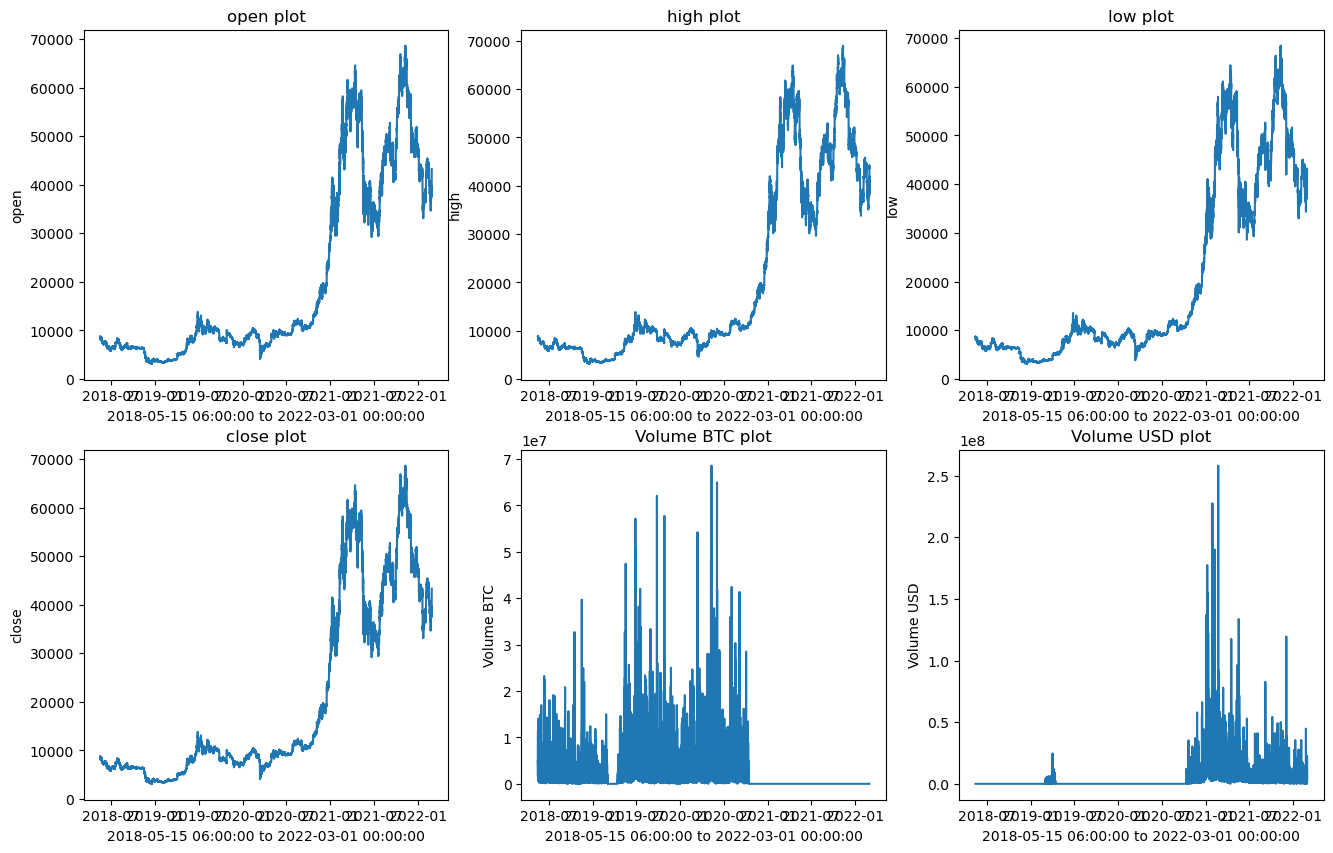

In [24]:
fig, axs = plt.subplots(len(data.columns)//3, 3, figsize = (16, 10))
for idx, i in enumerate(data.columns):
    row, col = 0 if idx<=2 else 1, idx%3
    axs[row, col].plot(data[i])
    axs[row, col].set_xlabel(f'{data.index[0]} to {data.index[-1]}')
    axs[row, col].set_ylabel(i)
    axs[row, col].set_title(f'{i} plot')
plt.show()

In [45]:
data.corr()

,open,high,low,close,Volume BTC,Volume USD
open,1.000000,0.999958,0.999936,0.999924,-0.325680,0.479441
high,0.999958,1.000000,0.999905,0.999958,-0.324982,0.482761
low,0.999936,0.999905,1.000000,0.999948,-0.326909,0.474078
close,0.999924,0.999958,0.999948,1.000000,-0.325917,0.479253
Volume BTC,-0.325680,-0.324982,-0.326909,-0.325917,1.000000,-0.210158
Volume USD,0.479441,0.482761,0.474078,0.479253,-0.210158,1.000000


In [39]:
sns.heatmap(data.corr(), xticklabels=data.columns, yticklabels=data.columns)

<Axes: >

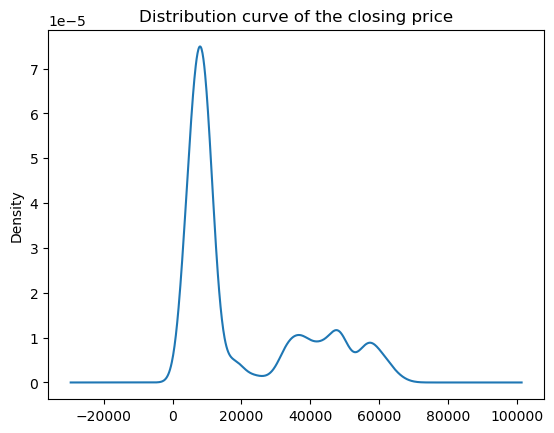

In [42]:
data['close'].plot.kde()
plt.title('Distribution curve of the closing price')
plt.show()

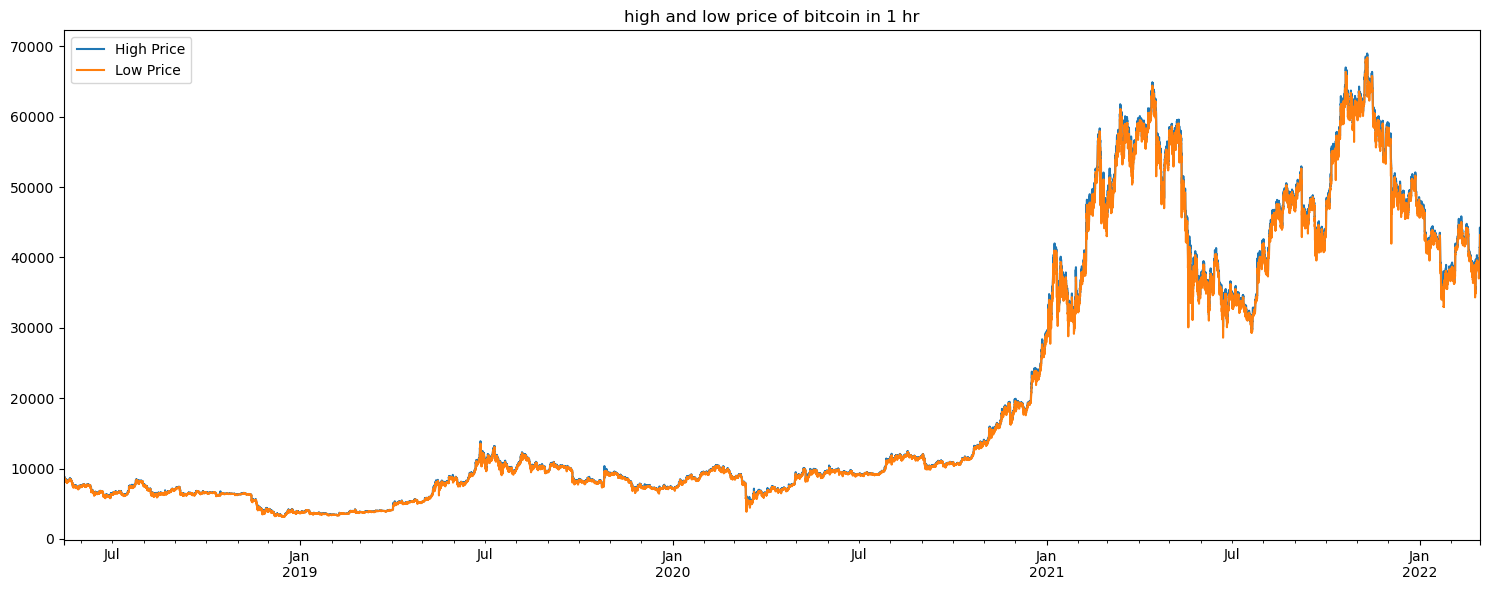

In [43]:
plt.figure(figsize=(15,6))
data['high'].plot()
data['low'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title('high and low price of bitcoin in 1 hr')
plt.legend(['High Price', 'Low Price'])
plt.tight_layout()
plt.show()

In [44]:
data[:20]

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69
2018-05-15 11:00:00,8795.90,8821.19,8740.54,8760.00,2842987.30,324.11
2018-05-15 12:00:00,8760.00,8798.60,8741.52,8760.00,2842401.44,324.20
2018-05-15 13:00:00,8760.00,8771.02,8700.00,8759.23,6380081.87,730.67
2018-05-15 14:00:00,8759.23,8761.70,8467.42,8517.77,11484106.74,1341.75


In [47]:
n_cols = 1
dataset = data['close']
dataset = pd.DataFrame(dataset)
data1=dataset.values

data1.shape

(33259, 1)

In [48]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(data1))

In [52]:
train_data=scaled_data[0:train_size, :]
train_data.shape

(24944, 1)

In [53]:
x_train = []
y_train = []
time_steps = 60
n_cols=1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i <=time_steps:
        print('X_train:', x_train)
        print('y_train:', y_train)


X_train: [array([[0.08553161],
       [0.08550122],
       [0.08534073],
       [0.08503274],
       [0.08637009],
       [0.0858219 ],
       [0.0858219 ],
       [0.08581014],
       [0.08212301],
       [0.08216164],
       [0.08238963],
       [0.08255928],
       [0.08225861],
       [0.08270068],
       [0.08203643],
       [0.08173377],
       [0.08124085],
       [0.08146975],
       [0.08117855],
       [0.07919893],
       [0.07625408],
       [0.07673295],
       [0.07771925],
       [0.07758212],
       [0.0778631 ],
       [0.07777438],
       [0.07738483],
       [0.0779341 ],
       [0.07988379],
       [0.07991235],
       [0.07979141],
       [0.07696506],
       [0.07765237],
       [0.07858079],
       [0.07839144],
       [0.07875793],
       [0.07849055],
       [0.07807566],
       [0.07883092],
       [0.07873426],
       [0.07845023],
       [0.07950906],
       [0.07968788],
       [0.07994442],
       [0.07984547],
       [0.07981645],
       [0.07902317],
   

In [54]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (X_train.shape[]))